<a href="https://colab.research.google.com/github/KrishnaSChavan/MachineLearning/blob/main/Clav_Cell_segmentation_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate,Input
from tensorflow.keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
from google. colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnaschavan","key":"6f1c6fc054fb8d6259f3b6411ea6191e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

100% 6.40G/6.40G [03:39<00:00, 23.3MB/s]
100% 6.40G/6.40G [03:40<00:00, 31.2MB/s]


In [5]:
import zipfile
zip_r = zipfile.ZipFile('/content/cervical-cancer-largest-dataset-sipakmed.zip')
zip_r.extractall()
zip_r.close()

In [6]:
one = "/content/im_Dyskeratotic/im_Dyskeratotic/"
two = "/content/im_Koilocytotic/im_Koilocytotic/"
three = "/content/im_Metaplastic/im_Metaplastic/"
four = "/content/im_Parabasal/im_Parabasal/CROPPED/"
five = "/content/im_Superficial-Intermediate/im_Superficial-Intermediate/"

In [7]:
path = [one,two,three,four,five]

In [ ]:
data = []
labels = []
height = 64
width = 64
channels = 3
classes = 43
n_inputs = height * width * channels

i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                print(p+a)

                image=cv2.imread(p+a)


                image_from_array = Image.fromarray(image, 'RGB')

                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except:
                print('')
    i+=1

In [9]:
len(data)

1645

In [11]:
data = np.array(data)

In [12]:
data.dtype,data.shape

(dtype('uint8'), (1645, 64, 64, 3))

In [21]:
def preprocess_image(image):

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    image_uint8 = cv2.convertScaleAbs(image_gray)


    ret, thresh1 = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    binary_image = np.expand_dims(thresh1, axis=-1)

    return binary_image

In [22]:
mask = []

for image in data:
    binary_image = preprocess_image(image)
    mask.append(binary_image)

In [28]:
mask = np.array(mask)

In [26]:
data.dtype

dtype('uint8')

In [29]:
mask.dtype

dtype('uint8')

In [30]:
data.shape

(1645, 64, 64, 3)

In [31]:
mask.shape

(1645, 64, 64, 1)

In [33]:
data_three_channels = np.repeat(mask[1:5], 3, axis=-1)

In [35]:
data_three_channels.shape

(4, 64, 64, 3)

In [41]:
def conv_block(inputs,num_filters):
    x = Conv2D(num_filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(num_filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def encoder(inputs,num_filters):
    x = conv_block(inputs,num_filters)
    p = MaxPool2D((2,2))(x)

    return x,p
def decoder(inputs,skip_features,num_filters):
    x = Conv2DTranspose(num_filters,(2,2),strides=2,padding='same')(inputs)
    x = Concatenate()([x,skip_features])
    x = conv_block(x,num_filters)

    return x

In [42]:
def unet(input_shape):
    inputs = Input(input_shape)

    # encoders
    s0,p0 = encoder(inputs,32)
    s1,p1 = encoder(p0,64)   # p = 256
    s2,p2 = encoder(p1,128)      # p = 128
    s3,p3 = encoder(p2,256)      # p = 64
    s4,p4 = encoder(p3,512)      # p = 32

    # Bridge
    b1 = conv_block(p4,1024)

    #decoder

    d1 = decoder(b1,s4,512)      # p = 32
    d2 = decoder(d1,s3,256)      # p = 64
    d3 = decoder(d2,s2,128)      # p = 128
    d4 = decoder(d3,s1,64)       # p = 256
    d5 = decoder(d4,s0,32)

    #output

    outputs = Conv2D(3,(1,1),padding="same",activation = "sigmoid")(d5)

    model = Model(inputs,outputs,name='U-Net')

    return model

In [43]:
input_shape = (256,256,3)
model = unet(input_shape=input_shape)

In [45]:
np.random.seed(42)
s = np.arange(data.shape[0])
np.random.shuffle(s)
Data = data[s]
Mask = mask[s]

In [47]:
Mask_3 = np.repeat(Mask, 3, axis=-1)

In [48]:
Mask_3.shape

(1645, 64, 64, 3)

In [ ]:
plt.imshow(Mask_3[1])

In [ ]:
plt.imshow(Data[1])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(Data, Mask_3, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1316, 64, 64, 3)
(329, 64, 64, 3)
(1316, 64, 64, 3)
(329, 64, 64, 3)


In [ ]:
plt.imshow(X_train[1])

In [ ]:
plt.imshow(y_train[1])

In [57]:
IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32
data_gen = ImageDataGenerator(rescale=(1/255.))

train_data = data_gen.flow(
    x = X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_data = data_gen.flow(
    x = X_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [86]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
history_1 = model.fit(
                train_data,
                epochs = 40,
                validation_data=test_data
)

Epoch 1/40
42/42 [==============================] - 10s 67ms/step - loss: 952.6008 - accuracy: 0.4590 - val_loss: 1734.0502 - val_accuracy: 0.9662
Epoch 2/40
42/42 [==============================] - 2s 58ms/step - loss: 959.5468 - accuracy: 0.2519 - val_loss: 664.6031 - val_accuracy: 0.6870
Epoch 3/40
42/42 [==============================] - 2s 50ms/step - loss: 1032.1859 - accuracy: 0.3378 - val_loss: 831.5042 - val_accuracy: 0.5275
Epoch 4/40
42/42 [==============================] - 2s 49ms/step - loss: 1003.9819 - accuracy: 0.3055 - val_loss: 629.1127 - val_accuracy: 0.9607
Epoch 5/40
42/42 [==============================] - 2s 49ms/step - loss: 999.2949 - accuracy: 0.3840 - val_loss: 584.6249 - val_accuracy: 0.9350
Epoch 6/40
42/42 [==============================] - 2s 49ms/step - loss: 1008.8787 - accuracy: 0.3908 - val_loss: 611.0878 - val_accuracy: 0.8176
Epoch 7/40
42/42 [==============================] - 2s 49ms/step - loss: 1036.2766 - accuracy: 0.3810 - val_loss: 725.1825 - 

In [63]:
model.predict(data[1]/255.)

ValueError: ignored

In [88]:
xyz = np.reshape(data[123],(data.shape[1],data.shape[2],data.shape[3]))

In [66]:
model.predict(xyz/255.)

ValueError: ignored

In [89]:
pree = cv2.resize(xyz, (256, 256))

In [90]:
image_from_array = Image.fromarray(xyz, 'RGB')
size_change = image_from_array.resize((256, 256))

In [91]:
yelllow = np.array(size_change)

In [92]:
yelllow.shape

(256, 256, 3)

In [93]:
finall = np.reshape(yelllow,(-1,yelllow.shape[0],yelllow.shape[1],yelllow.shape[2]))

In [94]:
finall.shape

(1, 256, 256, 3)

In [95]:
my_pred = model.predict(finall/255.)

1/1 [==============================] - 0s 308ms/step


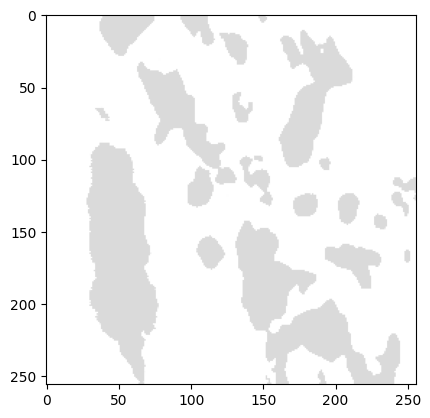

In [96]:
plt.imshow(np.reshape(my_pred,(yelllow.shape[0],yelllow.shape[1],yelllow.shape[2])))

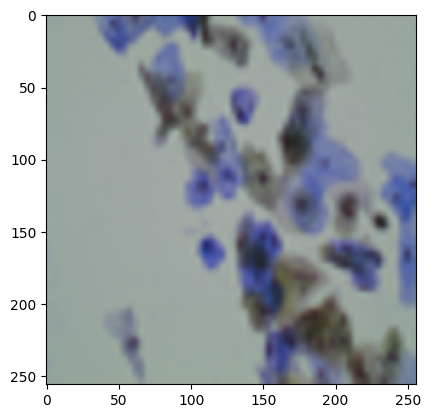

In [98]:
plt.imshow(yelllow)